In [2]:
%run setting.ipynb

In [13]:
import os
import re
import pandas as pd
import yfinance as yf

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.express as px

# configuration

In [22]:
leverage_ratio = 2

ETF = 'QQQ'
ETF_3x = 'QLD'

# data loading

## QQQ

In [23]:
qqq = yf.Ticker(ETF).history(
    period='max', 
    interval='1d', 
    actions=False)

qqq =  pd.read_csv(f'^NDX.csv', )

In [25]:
qqq = qqq.reset_index()
qqq['id'] = qqq.index
qqq['Date'] = pd.to_datetime(qqq['Date']).dt.date

In [26]:
qqq.to_sql(
name='qqq', 
con = conn,
if_exists='replace', 
index=False,
)

6442

In [27]:
df = sql(u"""
select * 
from qqq
order by Date asc
""")

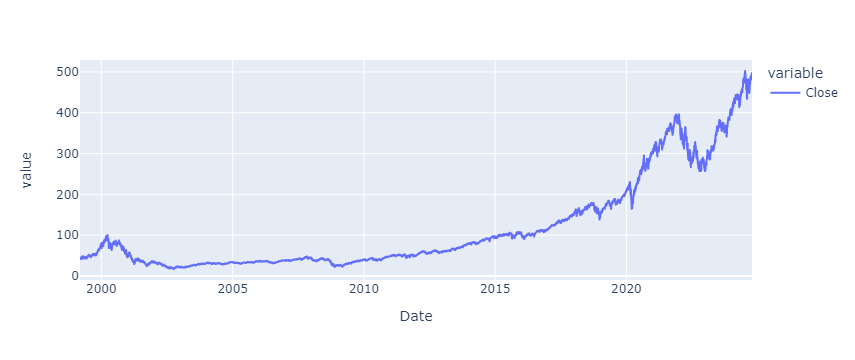

In [28]:
fig = px.line(df, x='Date', y=["Close"])
fig.show()

## QLD

In [7]:
data_3x = yf.Ticker(ETF_3x).history(
    period='max', 
    interval='1d', 
    actions=False)

data_3x =  pd.read_csv(f'QLD.csv', )

In [10]:
data_3x = data_3x.reset_index()
data_3x['id'] = data_3x.index
data_3x['Date'] = pd.to_datetime(data_3x['Date']).dt.date

In [11]:
data_3x.to_sql(
name='qld', 
con = conn,
if_exists='replace', 
index=False,
)

4610

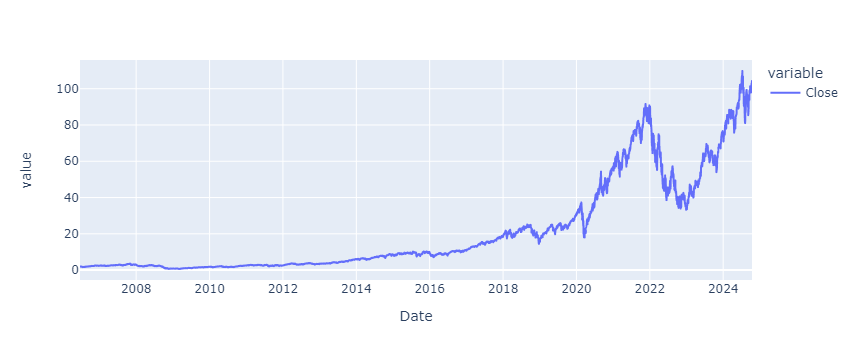

In [12]:
df = sql(u"""
select * 
from qld
order by Date asc
""")

fig = px.line(df, x='Date', y=["Close"])
fig.show()

# daily percentage

In [29]:
sql_to_table(
f"""
select qqq.*, 
pre_day.Date as pre_Date,
pre_day.Close as pre_Close,
(qqq.Close - pre_day.Close)/pre_day.Close AS Percent    
from qqq 
left join qqq as pre_day on pre_day.id+1 = qqq.id
order by qqq.Date asc
""",
'qqq'
)

6442

In [30]:
sql(u"""
select * 
from qqq
order by Date asc
limit 2
""")

Date       Open       High        Low      Close   Volume  id  \
0  1999-03-10  43.470428  43.496999  42.753007  43.417286  5232000   0   
1  1999-03-11  43.736129  43.988555  42.779568  43.629845  9688600   1   

     pre_Date  pre_Close   Percent  
0        None        NaN       NaN  
1  1999-03-10  43.417286  0.004896

# simulation

In [31]:
data_list = sql(f"""
select 
Date,
Percent, 
{leverage_ratio}*Percent as Leveraged_Percent
from qqq
where Percent is not null
order by Date asc
""".format(leverage_ratio)).to_dict('records')

In [32]:
data_list[0:3]

[{'Date': '1999-03-11',
  'Percent': 0.004895717036148142,
  'Leveraged_Percent': 0.009791434072296283},
 {'Date': '1999-03-12',
  'Percent': -0.02436029056503011,
  'Leveraged_Percent': -0.04872058113006022},
 {'Date': '1999-03-15',
  'Percent': 0.028714133545831473,
  'Leveraged_Percent': 0.057428267091662946}]

In [33]:
start_price = qqq['Close'][0]

qqq_price = start_price
tqqq_price = start_price

for r in data_list:
    ###
    qqq_price = qqq_price*(1+r['Percent'])
    r['price'] = qqq_price
    ###
    tqqq_price = tqqq_price*(1+r['Leveraged_Percent'])    
    r['Leveraged_price'] = tqqq_price  

data1 = pd.DataFrame(data_list)

In [34]:
data1.to_sql(
name='leveraged', 
con = conn,
if_exists='replace', 
index=False,
)

6441

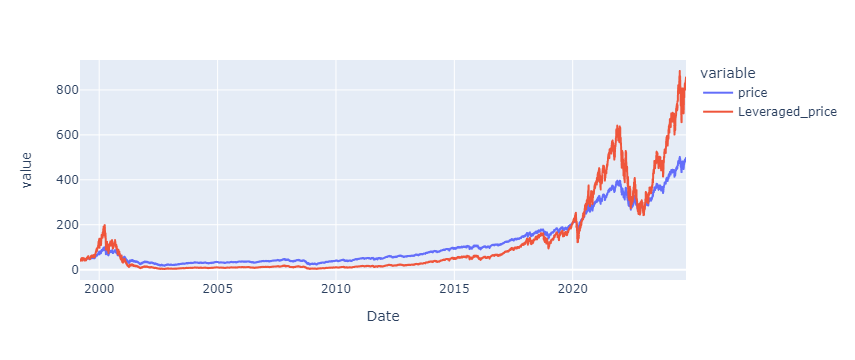

In [35]:
df = sql(u"""
select * 
from leveraged
order by Date asc
""")

fig = px.line(df, 
    x='Date', 
    y=[
    'price', 
    'Leveraged_price',
    ])
fig.show()

# regression

In [36]:
compare_3x = sql(u"""
select 
qld.Date,
leveraged.`Leveraged_price`,
qld.Close
from qld
join leveraged on leveraged.Date = qld.Date
order by qld.Date asc
""")

compare_3x.to_sql(
name='compare_3x', 
con = conn,
if_exists='replace', 
index=False,
)

4610

In [37]:
X = compare_3x['Leveraged_price'].to_numpy()
X = np.array([[i] for i in X])
y = compare_3x['Close'].to_numpy()

In [38]:
reg = LinearRegression().fit(X, y)

In [39]:
reg.score(X, y)

print(reg.coef_)

print(reg.intercept_)

[0.13137425]
1.5773127442881325


In [40]:
result = sql(f"""
select 
Date,
`Leveraged_price` * {reg.coef_[0]} + {reg.intercept_} AS simulated_Close,
Close
from compare_3x
""")

result.plot(x ='Date', y=[
    'simulated_Close', 
    'Close',
    ], grid = True)

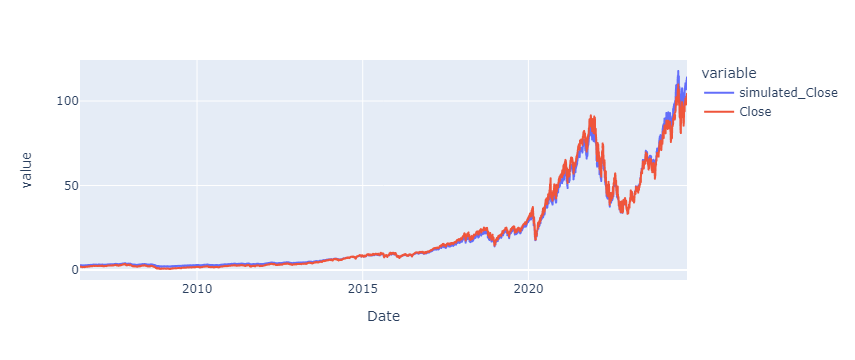

In [41]:
fig = px.line(result, x='Date', y=["simulated_Close",'Close'])
fig.show()

all simulation results

In [42]:
final_result = sql(f"""
select 
data1.Date,
data1.price AS {ETF},
data1.`Leveraged_price` * {reg.coef_[0]} + {reg.intercept_} AS simulated_{ETF_3x},
data_3x.Close as {ETF_3x}
from leveraged as data1
left join qld as data_3x 
on data_3x.Date = data1.Date
""")

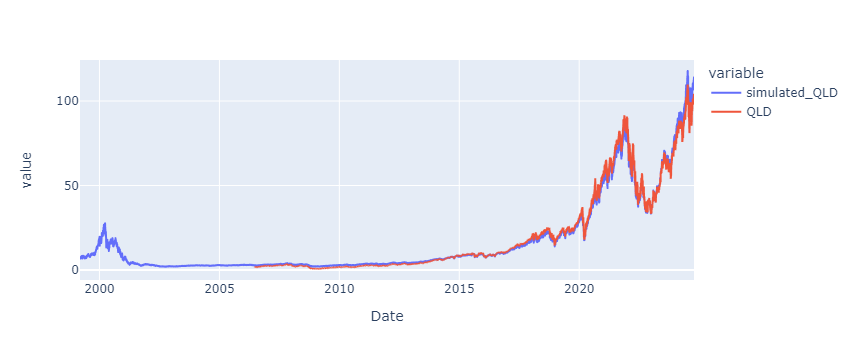

In [43]:
fig = px.line(
final_result, x='Date', y=[
f'simulated_{ETF_3x}',
ETF_3x])
fig.show()

final_result.plot(x ='Date', y=[
    'simulated_{}'.format(ETF_3x),
    ETF_3x,
    ], grid = True)

In [44]:
final_result.to_excel(
f'{ETF_3x}_simulation.xlsx',
index = False,
)

In [45]:
print(f'{ETF_3x}_simulation.xlsx')

QLD_simulation.xlsx


# simulated

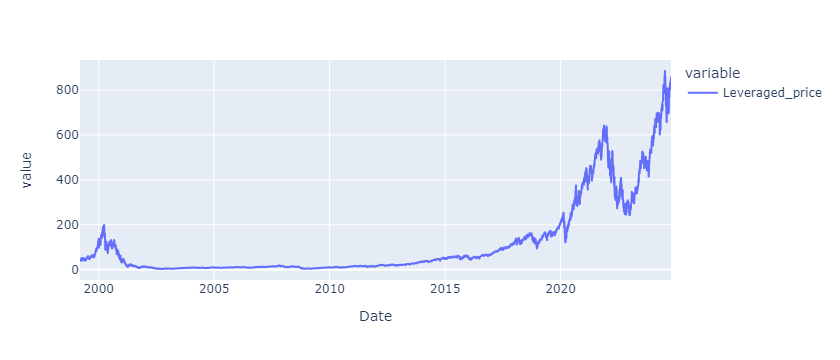

In [46]:
df = sql(f"""
select Date, Leveraged_price
from leveraged
order by Date
""")

fig = px.line(
df, x='Date', y=['Leveraged_price'])
fig.show()

In [47]:
sql(f"""
select * 
from leveraged
limit 3
""")

Date   Percent  Leveraged_Percent      price  Leveraged_price
0  1999-03-11  0.004896           0.009791  43.629845        43.842403
1  1999-03-12 -0.024360          -0.048721  42.567009        41.706376
2  1999-03-15  0.028714           0.057428  43.789284        44.101501

# retio of holding x years

In [52]:
year = 1

df = sql(f"""
with 

a as (
select a.Date as before_date, 
b.Date as after_date,
a.Leveraged_price as before_price_leveraged,
b.Leveraged_price as after_price_leverage,
a.price as before_price,
b.price as after_price
from leveraged as a 
join leveraged as b
on 
Cast ((
    JulianDay(b.Date) - JulianDay(a.Date)
) As Integer) = {year} * 365
)

select after_date, 
after_price/before_price as price_ratio,
after_price_leverage/before_price_leveraged as price_ratio_leverage
from a 
""")

df.to_sql(
name='price_ratio', 
con = conn,
if_exists='replace', 
index=False,
)

sql(f"""
select price_ratio, price_ratio_leverage
from price_ratio
""").median()

price_ratio             1.154869
price_ratio_leverage    1.286382
dtype: float64

In [53]:
year = 2

df = sql(f"""
with 

a as (
select a.Date as before_date, 
b.Date as after_date,
a.Leveraged_price as before_price_leveraged,
b.Leveraged_price as after_price_leverage,
a.price as before_price,
b.price as after_price
from leveraged as a 
join leveraged as b
on 
Cast ((
    JulianDay(b.Date) - JulianDay(a.Date)
) As Integer) = {year} * 365
)

select after_date, 
after_price/before_price as price_ratio,
after_price_leverage/before_price_leveraged as price_ratio_leverage
from a 
""")

df.to_sql(
name='price_ratio', 
con = conn,
if_exists='replace', 
index=False,
)

sql(f"""
select price_ratio, price_ratio_leverage
from price_ratio
""").median()

price_ratio             1.271575
price_ratio_leverage    1.502462
dtype: float64

In [54]:
year = 3

df = sql(f"""
with 

a as (
select a.Date as before_date, 
b.Date as after_date,
a.Leveraged_price as before_price_leveraged,
b.Leveraged_price as after_price_leverage,
a.price as before_price,
b.price as after_price
from leveraged as a 
join leveraged as b
on 
Cast ((
    JulianDay(b.Date) - JulianDay(a.Date)
) As Integer) = {year} * 365
)

select after_date, 
after_price/before_price as price_ratio,
after_price_leverage/before_price_leveraged as price_ratio_leverage
from a 
""")

df.to_sql(
name='price_ratio', 
con = conn,
if_exists='replace', 
index=False,
)

sql(f"""
select price_ratio, price_ratio_leverage
from price_ratio
""").median()

price_ratio             1.497236
price_ratio_leverage    2.004382
dtype: float64

In [55]:
year = 5

df = sql(f"""
with 

a as (
select a.Date as before_date, 
b.Date as after_date,
a.Leveraged_price as before_price_leveraged,
b.Leveraged_price as after_price_leverage,
a.price as before_price,
b.price as after_price
from leveraged as a 
join leveraged as b
on 
Cast ((
    JulianDay(b.Date) - JulianDay(a.Date)
) As Integer) = {year} * 365
)

select after_date, 
after_price/before_price as price_ratio,
after_price_leverage/before_price_leveraged as price_ratio_leverage
from a 
""")

df.to_sql(
name='price_ratio', 
con = conn,
if_exists='replace', 
index=False,
)

sql(f"""
select price_ratio, price_ratio_leverage
from price_ratio
""").median()

price_ratio             1.998126
price_ratio_leverage    3.159109
dtype: float64

In [56]:
year = 10

df = sql(f"""
with 

a as (
select a.Date as before_date, 
b.Date as after_date,
a.Leveraged_price as before_price_leveraged,
b.Leveraged_price as after_price_leverage,
a.price as before_price,
b.price as after_price
from leveraged as a 
join leveraged as b
on 
Cast ((
    JulianDay(b.Date) - JulianDay(a.Date)
) As Integer) = {year} * 365
)

select after_date, 
after_price/before_price as price_ratio,
after_price_leverage/before_price_leveraged as price_ratio_leverage
from a 
""")

df.to_sql(
name='price_ratio', 
con = conn,
if_exists='replace', 
index=False,
)

sql(f"""
select price_ratio, price_ratio_leverage
from price_ratio
""").median()

price_ratio             3.202664
price_ratio_leverage    6.443742
dtype: float64

In [60]:
year = 20

df = sql(f"""
with 

a as (
select a.Date as before_date, 
b.Date as after_date,
a.Leveraged_price as before_price_leveraged,
b.Leveraged_price as after_price_leverage,
a.price as before_price,
b.price as after_price
from leveraged as a 
join leveraged as b
on 
Cast ((
    JulianDay(b.Date) - JulianDay(a.Date)
) As Integer) = {year} * 365
)

select after_date, 
after_price/before_price as price_ratio,
after_price_leverage/before_price_leveraged as price_ratio_leverage
from a 
""")

df.to_sql(
name='price_ratio', 
con = conn,
if_exists='replace', 
index=False,
)

sql(f"""
select price_ratio, price_ratio_leverage
from price_ratio
""").median()

price_ratio             11.333627
price_ratio_leverage    45.779256
dtype: float64

In [61]:
sql(f"""
select price_ratio, price_ratio_leverage
from price_ratio
""")

price_ratio  price_ratio_leverage
0        3.832624              3.121332
1        3.880108              3.200655
2        3.812029              3.090663
3        3.860851              3.170409
4        3.815851              3.097883
...           ...                   ...
1099    15.880359             99.331195
1100    16.153736            102.758827
1101    16.354328            105.322449
1102    16.253221            104.026733
1103    16.300844            104.656068

[1104 rows x 2 columns]

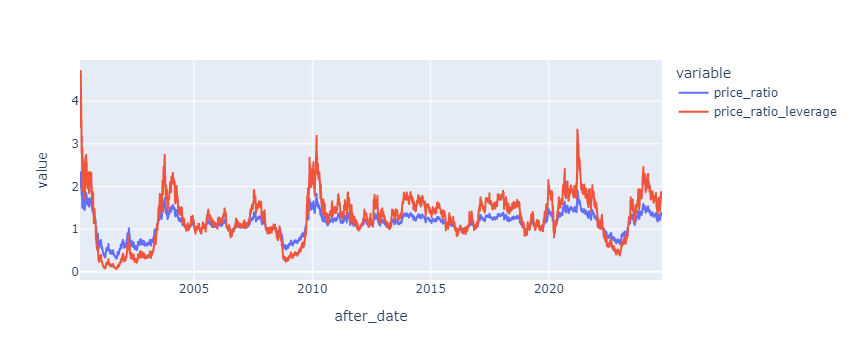

In [51]:
df = sql(f"""
select * 
from price_ratio
""")

fig = px.line(
df, x='after_date', y=['price_ratio', 'price_ratio_leverage'])
fig.show()

In [50]:
year = 1

df = sql(f"""
with 

a as (
select a.Date as before_date, 
b.Date as after_date,
a.Leveraged_price as before_price_leveraged,
b.Leveraged_price as after_price_leverage,
a.price as before_price,
b.price as after_price
from leveraged as a 
join leveraged as b
on 
Cast ((
    JulianDay(b.Date) - JulianDay(a.Date)
) As Integer) = {year} * 365
)

select after_date, 
after_price/before_price as price_ratio,
after_price_leverage/before_price_leveraged as price_ratio_leverage
from a 
""")

df.to_sql(
name='price_ratio', 
con = conn,
if_exists='replace', 
index=False,
)

sql(f"""
select price_ratio, price_ratio_leverage
from price_ratio
""").median()

price_ratio             1.154869
price_ratio_leverage    1.286382
dtype: float64

# END